<font size=6>Ocean Data Analysis - Analyzing Sea Surface Temperature w/ Variational Inference</font>

Rapid warming of sea surface temperatures is alarming scientists as temperature recordings from a globally distributed of NOAA buoys rise higher than expected for this time of year. In this post, I use the previously discussed Variational inference model in combination with Extreme value theory (EVT) as an anomaly detection method to explore these extreme outlier values.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
!pip install netcdf4
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 
import scipy.stats as stats 

import seaborn as sns
sns.set()

In [103]:
# Buoy in Gulf of Maine
ds = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44007/44007.ncml')
ds = ds.sel(time=slice('2020-4-24','2023-4-24'))
print(ds)

# Get buoy data from NOAA
noaa_df = ds.to_dataframe().reset_index()
print(noaa_df)

<xarray.Dataset>
Dimensions:                  (latitude: 1, longitude: 1, time: 134050)
Coordinates:
  * latitude                 (latitude) float32 43.53
  * longitude                (longitude) float32 -70.14
  * time                     (time) datetime64[ns] 2020-04-24T00:50:00 ... 20...
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_tem

In [104]:
# Get sea surface temps
cov = noaa_df[['time','sea_surface_temperature']]
cov = cov.dropna().reset_index().drop(columns=['index'])
print(cov)

                      time  sea_surface_temperature
0      2020-04-24 00:50:00                      5.9
1      2020-04-24 01:50:00                      5.9
2      2020-04-24 02:50:00                      5.8
3      2020-04-24 03:50:00                      5.8
4      2020-04-24 04:50:00                      5.7
...                    ...                      ...
133316 2023-04-24 23:10:00                      7.1
133317 2023-04-24 23:20:00                      7.1
133318 2023-04-24 23:30:00                      7.1
133319 2023-04-24 23:40:00                      7.1
133320 2023-04-24 23:50:00                      7.1

[133321 rows x 2 columns]


In [105]:
# Block maxima approach for 2-day blocks (6 records per hour)
win_len = 6*24*1

# Block maxima lambda 
block_maxima = lambda serie:[ max(serie[(BL * win_len) : (BL * win_len) + win_len]) for BL in range(0, int(len(serie)/ win_len)) ]

# Calculate block maxima
np_maxima = np.array(block_maxima(cov['sea_surface_temperature'])).reshape(-1,1)

# Fit mixture model 
num_components = 2
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=1,
    max_iter=100)
p = dpgmm_model.fit_predict(np_maxima)

# Count States
state_counts = np.zeros(num_components)
for M in p:
  state_counts[M] += 1 
print(state_counts)

[425. 500.]


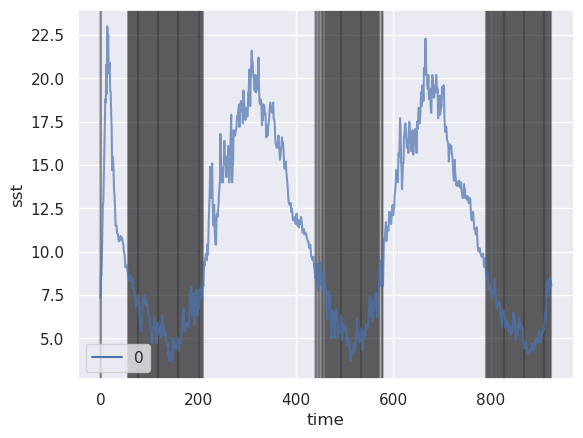

In [106]:
# Plot States
fig2, ax2=plt.subplots()

for M in range(len(p)): 
  if p[M] == p[-1]:
    ax2.axvline(M, color='black', alpha=0.2) 
    
sns.lineplot(data=np_maxima, ax=ax2, alpha=0.7)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

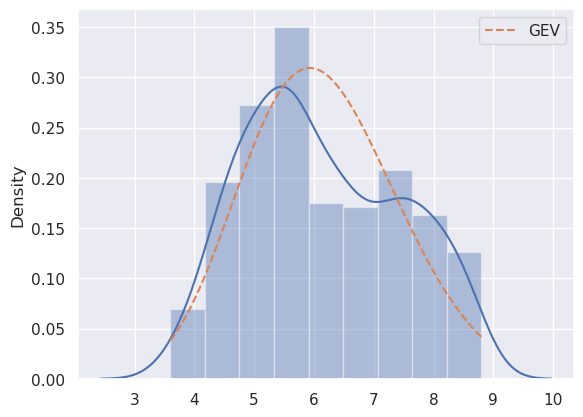

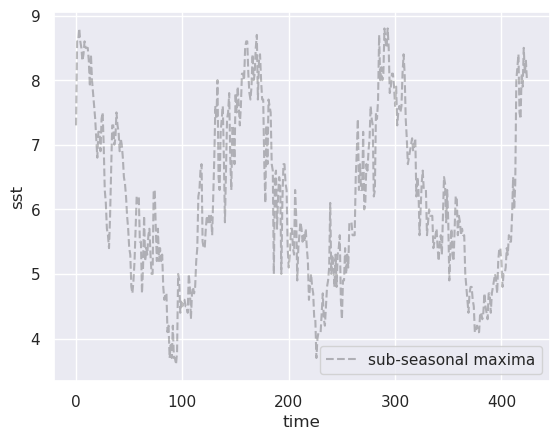

In [107]:
# Subseasons
subseasonal_maxima = []
subseasons = {}

# Gather up data that matches the most recent latent state 
for M in range(len(p)): 
  if p[M] == p[-1]:
    subseasonal_maxima.append(np_maxima[M][0])
    
    # Use win_len needed to offset block maxima for per-year dictionary
    year = str(cov['time'][M*win_len])[:4] 
    if year not in subseasons:
        subseasons[year] = [] 
    subseasons[year].append(np_maxima[M][0])
    
# Find block maxima and fit GEV 
gev_fit = stats.genextreme.fit(subseasonal_maxima)
x = np.linspace(min(subseasonal_maxima), max(subseasonal_maxima), 200)

# GEV 
fig,ax = plt.subplots()
sns.distplot(subseasonal_maxima)
plt.plot(x, stats.genextreme.pdf(x, *gev_fit), linestyle='--', label='GEV')
plt.legend()
plt.show()

# sub-seasonal data 
sns.lineplot(data=subseasonal_maxima, color='black', alpha=0.25, linestyle='--', label='sub-seasonal maxima')
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

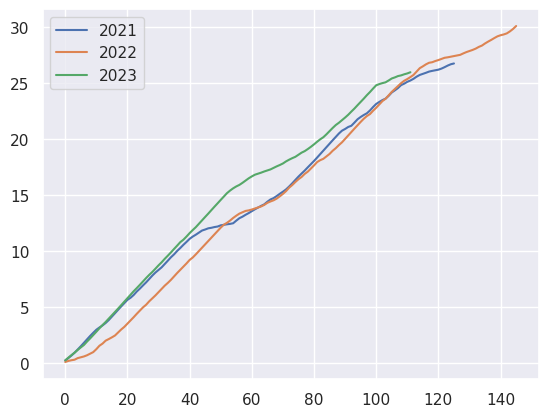

In [110]:
# Cumulative anomaly score each sub-season
score = lambda subseason: np.cumsum([ stats.genextreme.pdf(x, *gev_fit) for x in subseason ])

# Plot data
sns.lineplot(data=score(subseasons['2021']), label='2021')
sns.lineplot(data=score(subseasons['2022']), label='2022')
sns.lineplot(data=score(subseasons['2023']), label='2023')
plt.legend()
plt.show()